In [46]:
import numpy as np
from src import data
from netneurotools import networks
import os
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
from matplotlib.colors import LogNorm

In [47]:
def plot_adjacency_matrix(matrix,ax,title,norm=None,mask=None):

    g =sns.heatmap(matrix,ax=ax,square=True,cbar=False,yticklabels=False, xticklabels=False,cmap='gray',norm=norm,mask=mask)
    g.set_facecolor('k')
    ax.set_title(title)

In [48]:
SC_W, SC_L, _ = data.load_pytepfit_sc()
SC_W_ENIGMA, _, FC_ENIGMA = data.load_enigma(parcellation="schaefer_200",reoreder='PyTepFit')
SC_W_ENIGMA = np.where(SC_W_ENIGMA==0,np.nan,SC_W_ENIGMA)
SC_W_dom, SC_L_dom, FC_dom = data.load_domhof_for_pytepfit()

data: <https://doi.org/10.5281/zenodo.2872624>

In [49]:
mapping_17 = data.path('external/schaefer_parcellation_centroids/ROI_MAPPING_7_17.csv')
mapping_csv = data.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')

centroids_file = data.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')
centroids_mne = data.get_centroids_from_file(centroids_file,"geom_mne")
ED = data.roi_distances_from_centroids(centroids_mne)

In [50]:
M = np.zeros((200,200,200)) # roi x roi x subjects
L = np.zeros((200,200,200)) # roi x roi x subjects

for i in range(200):
    counts_file = data.path(f"external/domhof/Schaefer/1StructuralConnectivity/{i:03d}/Counts.csv")
    with open(counts_file,"r") as cf:
        c = np.genfromtxt(cf)
    M[:,:,i] = data.roi_remappnig.schaefer_to_schaefer(data.roi_remappnig.schaefer_to_schaefer(c,mapping_17,"idx_17"),mapping_csv,"idx_csv")

    lengths_file = data.path(f"external/domhof/Schaefer/1StructuralConnectivity/{i:03d}/Lengths.csv")
    with open(lengths_file,"r") as lf:
        l = np.genfromtxt(lf)
    L[:,:,i] = data.roi_remappnig.schaefer_to_schaefer(data.roi_remappnig.schaefer_to_schaefer(l,mapping_17,"idx_17"),mapping_csv,"idx_csv")

L_mean = np.mean(L,axis=2)
M_divided = np.divide(M,L_mean)

In [51]:
parcellation = pd.read_csv(data.path("external/schaefer_parcellation_centroids/test.csv"))
parcellation

,ROI Name,R,A,S,surf_area,n_vertices
0,7Networks_LH_Cont_Cing_1-lh,-8.446814,-29.013483,28.885052,0.000435,79
1,7Networks_LH_Cont_Cing_2-lh,-6.240661,2.739428,30.226892,0.000251,45
2,7Networks_LH_Cont_PFCl_1-lh,-31.280493,38.780682,-8.203615,0.000432,52
3,7Networks_LH_Cont_PFCl_2-lh,-39.062012,44.742603,-4.839688,0.000482,67
4,7Networks_LH_Cont_PFCl_3-lh,-25.701366,47.526104,5.547397,0.000489,77
...,...,...,...,...,...,...
195,7Networks_RH_Vis_5-rh,41.960854,-77.031326,-3.239134,0.000460,72
196,7Networks_RH_Vis_6-rh,13.508061,-93.161369,-5.076058,0.000892,120
197,7Networks_RH_Vis_7-rh,22.263935,-47.680222,-2.569446,0.000443,76
198,7Networks_RH_Vis_8-rh,29.157928,-94.473122,-2.708371,0.000946,129


In [52]:
area = np.zeros((200,200))

for i, i_vert in enumerate(parcellation.n_vertices):
    for j, j_vert in enumerate(parcellation.n_vertices):
        area[i,j] = i_vert + j_vert

area

array([[158., 124., 131., ..., 155., 208., 178.],
       [124.,  90.,  97., ..., 121., 174., 144.],
       [131.,  97., 104., ..., 128., 181., 151.],
       ...,
       [155., 121., 128., ..., 152., 205., 175.],
       [208., 174., 181., ..., 205., 258., 228.],
       [178., 144., 151., ..., 175., 228., 198.]])

In [75]:
L_mean = np.mean(L,axis=2)
M_divided = np.divide(M,L_mean)
M_multiplied = np.multiply(M,L_mean) / np.max(L_mean,axis=None)
M_divided_area = np.divide(M_divided,area)

In [76]:
hemi =  np.array([0] * 100 + [1] * 100).reshape(-1, 1)

Z článku o distance-consensus: Structural connectivity between pairs of parcels was estimated in terms of streamline density, defined as the number of streamlines between two parcels normalized by the mean length of the streamlines and the mean surface area of the parcels.

In [81]:
SC = networks.struct_consensus(M_multiplied, ED, hemi,                     
                                conn_num_inter=100*10,
                                conn_num_intra=100*30,
                                weighted=True) # L_mean místo ED

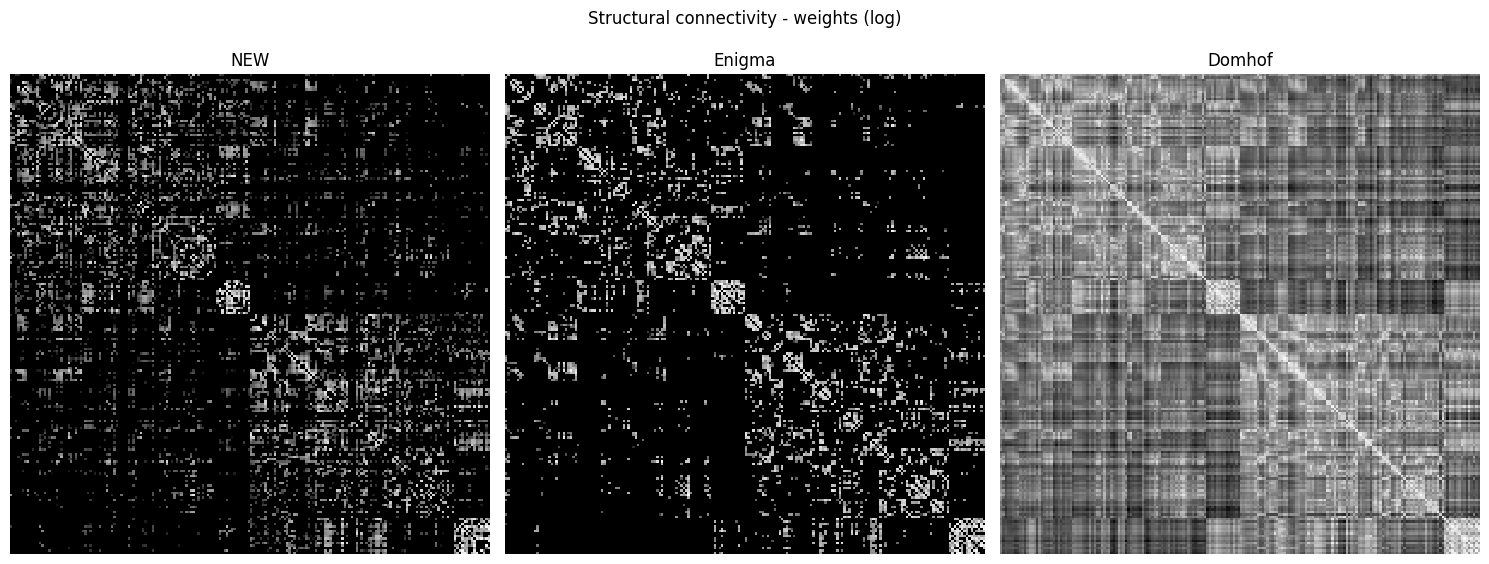

In [82]:
fig, axs = plt.subplots(1, 3, tight_layout=True,figsize=(15,6),sharey=True,sharex=True)
fig.suptitle("Structural connectivity - weights (log)")
plot_adjacency_matrix(SC,axs[0],"NEW",norm=LogNorm(),mask=SC_W==0)
plot_adjacency_matrix(SC_W_ENIGMA,axs[1],"Enigma",mask=SC_W_ENIGMA==0)
plot_adjacency_matrix(SC_W_dom,axs[2],"Domhof",norm=LogNorm())

In [83]:
df = pd.DataFrame({"PyTepFit":SC_W.flatten(),"Domhof_basic":SC_W_dom.flatten(),"Enigma": SC_W_ENIGMA.flatten(), "NEW": SC.flatten()})
pg.pairwise_corr(df,method="spearman")

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,PyTepFit,Domhof_basic,spearman,two-sided,40000,0.834412,"[0.83, 0.84]",0.000000e+00,1.0
1,PyTepFit,Enigma,spearman,two-sided,4822,0.782258,"[0.77, 0.79]",0.000000e+00,1.0
2,PyTepFit,NEW,spearman,two-sided,40000,0.506335,"[0.5, 0.51]",0.000000e+00,1.0
3,Domhof_basic,Enigma,spearman,two-sided,4822,0.871037,"[0.86, 0.88]",0.000000e+00,1.0
4,Domhof_basic,NEW,spearman,two-sided,40000,0.524185,"[0.52, 0.53]",0.000000e+00,1.0
5,Enigma,NEW,spearman,two-sided,4822,0.437541,"[0.41, 0.46]",1.005139e-224,1.0


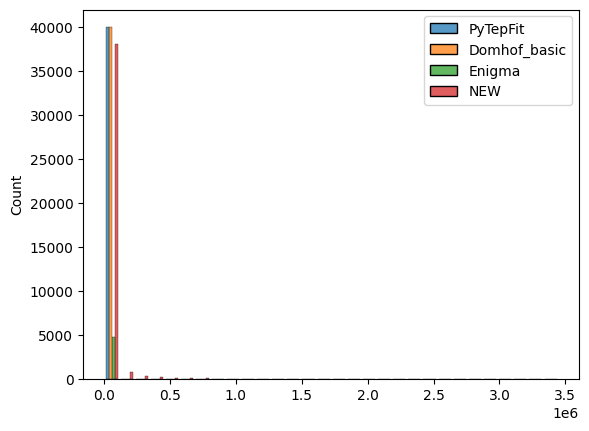

In [72]:
plt.figure()
sns.histplot(df,bins = 30, multiple="dodge", shrink=.8)
plt.show()

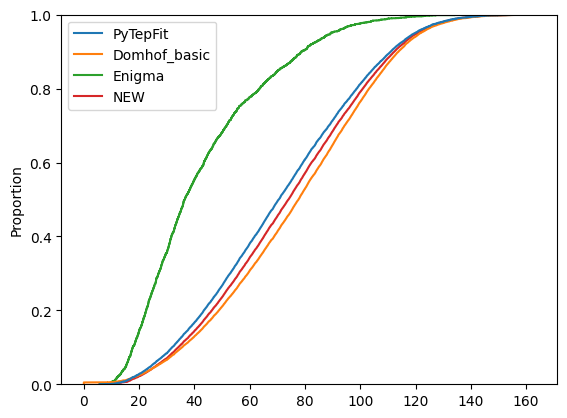

In [73]:
def get_lengths(matrix,ED):
    mask = matrix > 0
    return np.where(mask,ED,np.nan).flatten()

df_len = pd.DataFrame({"PyTepFit":get_lengths(SC_W,ED),"Domhof_basic":get_lengths(SC_W_dom,ED),"Enigma": get_lengths(SC_W_ENIGMA,ED), "NEW": get_lengths(SC,ED)})
plt.figure()
sns.ecdfplot(df_len)
plt.show()

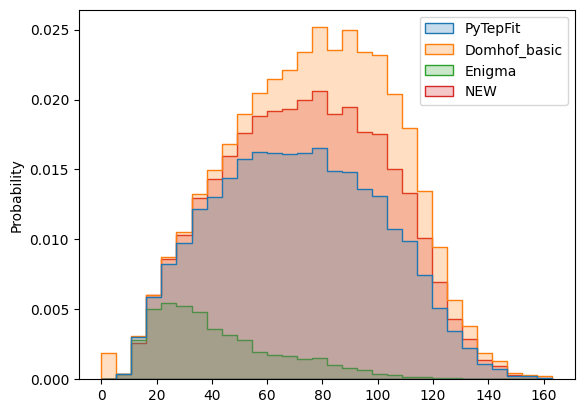

In [74]:
plt.figure()
sns.histplot(df_len,stat='probability',bins=30,element='step')
plt.show()